In this file, Model uses ["INNER_TPRT_1", "EXTN_TPRT", "INNER_HMDT_1", "DWP_TPRT"], which mean inner temperature, external temperature, inner humidity, dew point temperature.
- Input: "EXTN_TPRT", "INNER_HMDT_1", "DWP_TPRT"
- Target(output): INNER_TPRT_1

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

np.random.seed(42)

In [2]:
# columns used frequently
"EXTN_TPRT", "DWP_TPRT", "EXTN_SRQT", 
"INNER_HMDT_1", "INNER_HMDT_2",
"INNER_TPRT_1", "INNER_TPRT_2"

('INNER_TPRT_1', 'INNER_TPRT_2')

# define useful functions

In [3]:
def describe_df(df):
    print(df.describe())
    plt.figure(figsize=(15, 5)) 
    plt.plot(df)
    plt.suptitle('Original Dataset')
    plt.legend()
    plt.show()

In [4]:
def sliding_windows(data, seq_length, x_cols, y_cols):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length), x_cols]
        _y = data[i+seq_length, y_cols]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

def preprocess(df, x_cols, y_cols):
    training_data =df.to_numpy()

    seq_length = 4
    print(training_data.shape)
    x, y = sliding_windows(training_data, seq_length, x_cols, y_cols)
    train_size = int(len(y) * 0.8)
    test_size = len(y) - train_size

    print(x.shape, y.shape)

    dataX = Variable(torch.Tensor(np.array(x)))
    dataY = Variable(torch.Tensor(np.array(y)))

    trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
    trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

    testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
    testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

    print(trainX.shape, trainY.shape, testX.shape, testY.shape, sep="\n")
    print(trainX[0], trainY[0])
    print(trainX[1], trainY[1])
    print((trainX[1][-1]==trainY[0]).all())

    return train_size, dataX, dataY, trainX, trainY, testX, testY 

In [5]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        # self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        # self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [27]:
def train(trainX, trainY, epoch=None, hidden_size=64):
    num_epochs = epoch if epoch else 2000
    learning_rate = 0.01

    input_size = trainX.shape[-1]
    hidden_size = hidden_size
    num_layers = 1

    num_classes = trainY.shape[-1] # output_size

    lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

    criterion = torch.nn.MSELoss()    # mean-squared error for regression
    optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

    # Train the model
    for epoch in range(num_epochs):
        outputs = lstm(trainX)
        optimizer.zero_grad()
        
        # obtain the loss function
        loss = criterion(outputs, trainY)
        
        loss.backward()
        
        optimizer.step()
        if epoch % 100 == 0:
            print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
    return lstm

In [28]:
import sys 

def parameter_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    size_all_mb = (param_size + buffer_size) / 1024**2
    print('parameter size: {:.6f}MB'.format(size_all_mb))
    print('model dict size:', sys.getsizeof(model.state_dict()))

def save_model(model):
    parameter_size(model)
    torch.save(model.state_dict(), "./models/lstm.pt")

In [29]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

def eval(lstm, X, Y, train_size=None):
    lstm.eval()
    train_predict = lstm(X)
    print("X dataset shape & prediction shape:", X.shape, train_predict.shape)

    predict = train_predict.data.numpy()
    Y_plot = Y.data.numpy()

    # temp = np.empty((X.shape[0], X.shape[-1]+Y.shape[-1]))
    # temp[:,]
    # predict = sc.inverse_transform(predict)
    # Y_plot = sc.inverse_transform(Y_plot)

    regression_results(Y_plot, predict)

    plt.figure(figsize=(15, 5)) 
    if train_size:
        plt.axvline(x=train_size, c='r', linestyle='--')
    plt.plot(Y_plot)
    plt.plot(predict, linestyle='dotted')
    plt.suptitle('Time-Series Prediction')
    plt.show()

# 5min step

# Only One LSTM

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


         EXTN_TPRT     DWP_TPRT  INNER_TPRT_1  INNER_HMDT_1
count  5000.000000  5000.000000   5000.000000   5000.000000
mean      0.160968    14.474154     17.322960     84.517208
std       3.692765     1.822348      2.703058      6.544450
min      -8.600000     9.200000     13.430000     56.700000
25%      -2.500000    13.150000     15.350000     82.537500
50%       0.370000    13.950000     16.400000     85.800000
75%       2.635000    15.450000     18.570000     89.950000
max       9.200000    21.100000     27.050000     94.450000


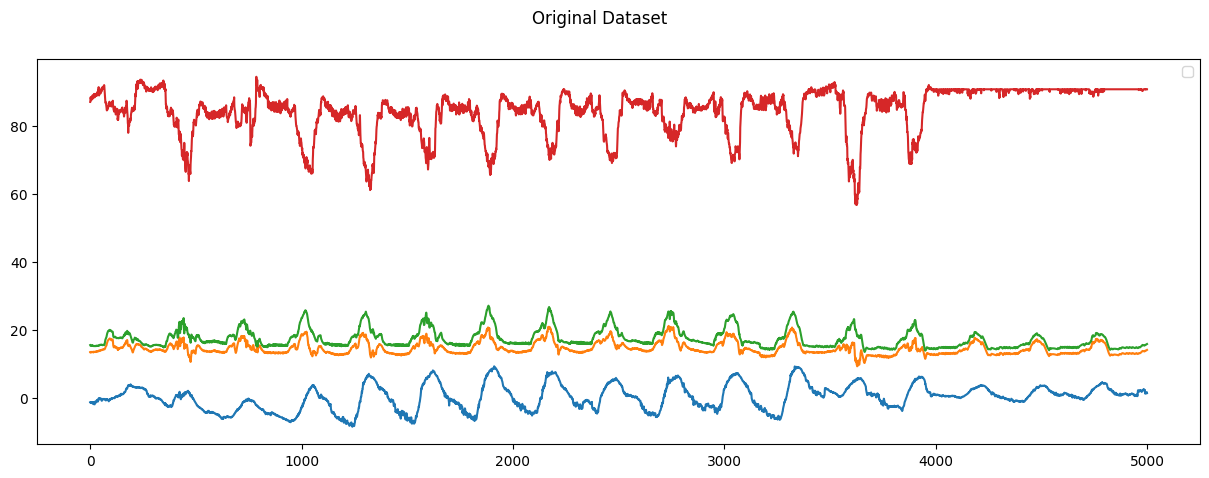

In [30]:
raw_df = pd.read_csv("merged.csv", usecols=["INNER_TPRT_1", "EXTN_TPRT", "INNER_HMDT_1", "DWP_TPRT"])
df = raw_df[:5000]
# df["MSRM_DT"] = (pd.to_datetime(df["MSRM_DT"]) - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

describe_df(df)

In [31]:
df.head()

,EXTN_TPRT,DWP_TPRT,INNER_TPRT_1,INNER_HMDT_1
0,-1.35,13.35,15.45,87.05
1,-1.30,13.25,15.30,87.45
2,-1.50,13.40,15.25,88.40
3,-1.55,13.40,15.30,87.95
4,-1.40,13.40,15.35,87.95


In [32]:
x_cols = [0,1, 3]
y_cols = [2]
train_size, dataX, dataY, trainX, trainY, testX, testY = preprocess(df, x_cols, y_cols)

(5000, 4)
(4995, 4, 3) (4995, 1)
torch.Size([3996, 4, 3])
torch.Size([3996, 1])
torch.Size([999, 4, 3])
torch.Size([999, 1])
tensor([[-1.3500, 13.3500, 87.0500],
        [-1.3000, 13.2500, 87.4500],
        [-1.5000, 13.4000, 88.4000],
        [-1.5500, 13.4000, 87.9500]]) tensor([15.3500])
tensor([[-1.3000, 13.2500, 87.4500],
        [-1.5000, 13.4000, 88.4000],
        [-1.5500, 13.4000, 87.9500],
        [-1.4000, 13.4000, 87.9500]]) tensor([15.4000])
tensor(False)


In [33]:
lstm = train(trainX, trainY)

Epoch: 0, loss: 316.39597
Epoch: 100, loss: 6.02625
Epoch: 200, loss: 2.02340
Epoch: 300, loss: 0.74828
Epoch: 400, loss: 0.40372
Epoch: 500, loss: 0.26624
Epoch: 600, loss: 0.20446
Epoch: 700, loss: 0.16785
Epoch: 800, loss: 0.15033
Epoch: 900, loss: 0.13649
Epoch: 1000, loss: 0.12700
Epoch: 1100, loss: 0.11959
Epoch: 1200, loss: 0.11474
Epoch: 1300, loss: 0.11618
Epoch: 1400, loss: 0.11616
Epoch: 1500, loss: 0.11090
Epoch: 1600, loss: 0.10325
Epoch: 1700, loss: 0.09785
Epoch: 1800, loss: 0.10420
Epoch: 1900, loss: 0.09522


In [34]:
save_model(lstm)

parameter size: 0.067631MB
model dict size: 744


X dataset shape & prediction shape: torch.Size([4995, 4, 3]) torch.Size([4995, 1])
explained_variance:  0.989
mean_squared_log_error:  0.0002
r2:  0.9889
MAE:  0.1945
MSE:  0.0814
RMSE:  0.2853


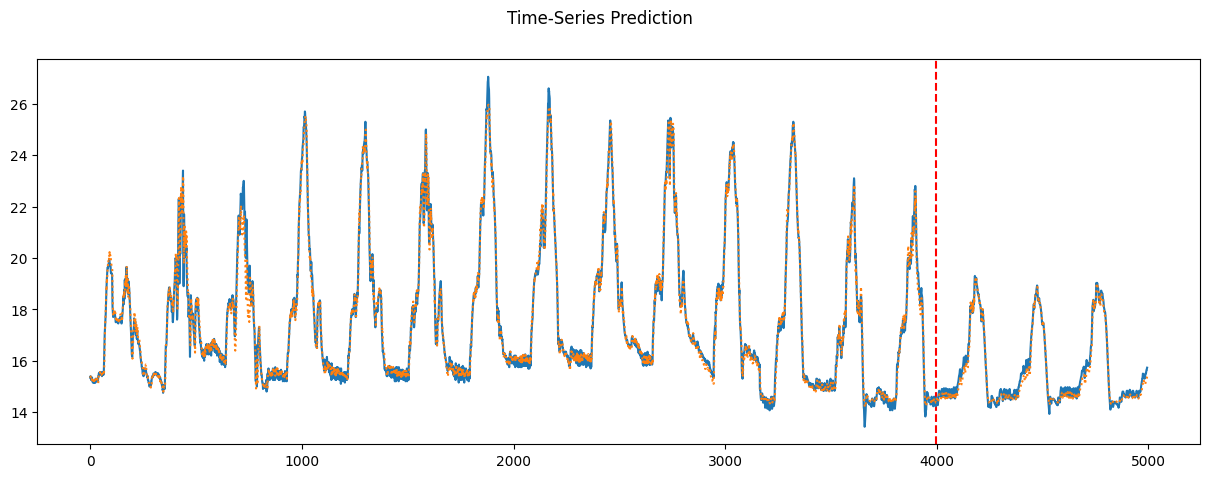

In [35]:
eval(lstm, dataX, dataY, train_size)

X dataset shape & prediction shape: torch.Size([999, 4, 3]) torch.Size([999, 1])
explained_variance:  0.9876
mean_squared_log_error:  1e-04
r2:  0.9825
MAE:  0.1475
MSE:  0.0354
RMSE:  0.1881


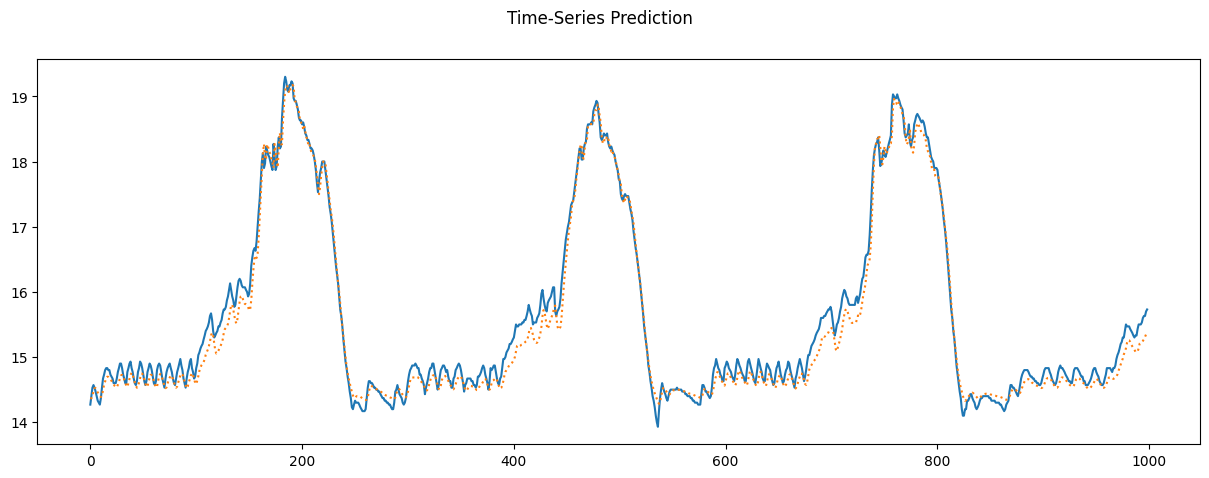

In [36]:
eval(lstm, testX, testY)

# Double Layer LSTM

dropout is useless when num_layer is 1

In [45]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class DoubleLayerLSTMWithDropout(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(DoubleLayerLSTMWithDropout, self).__init__()

        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Define two LSTM layers with dropout
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                             num_layers=num_layers, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size,
                             num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        # Propagate input through the first LSTM layer with dropout
        lstm_out1, _ = self.lstm1(x, (h_0, c_0))
        
        # Propagate the output of the first LSTM layer through the second LSTM layer with dropout
        lstm_out2, _ = self.lstm2(lstm_out1)

        # Reshape the output for the fully connected layer
        h_out = lstm_out2[:, -1, :].view(-1, self.hidden_size)

        # Fully connected layer
        out = self.fc(h_out)

        return out

    

In [46]:
LSTM=DoubleLayerLSTMWithDropout


In [47]:
lstm = train(trainX, trainY)

Epoch: 0, loss: 326.11743
Epoch: 100, loss: 7.72376
Epoch: 200, loss: 7.71802
Epoch: 300, loss: 7.71800
Epoch: 400, loss: 7.71796
Epoch: 500, loss: 7.71735
Epoch: 600, loss: 2.03640
Epoch: 700, loss: 0.23817
Epoch: 800, loss: 0.18096
Epoch: 900, loss: 0.19882
Epoch: 1000, loss: 0.14661
Epoch: 1100, loss: 0.18100
Epoch: 1200, loss: 0.12118
Epoch: 1300, loss: 0.11512
Epoch: 1400, loss: 0.10982
Epoch: 1500, loss: 0.10824
Epoch: 1600, loss: 0.10234
Epoch: 1700, loss: 0.10082
Epoch: 1800, loss: 0.09815
Epoch: 1900, loss: 0.09686


X dataset shape & prediction shape: torch.Size([4995, 4, 3]) torch.Size([4995, 1])
explained_variance:  0.9887
mean_squared_log_error:  0.0003
r2:  0.9849
MAE:  0.2469
MSE:  0.1102
RMSE:  0.332


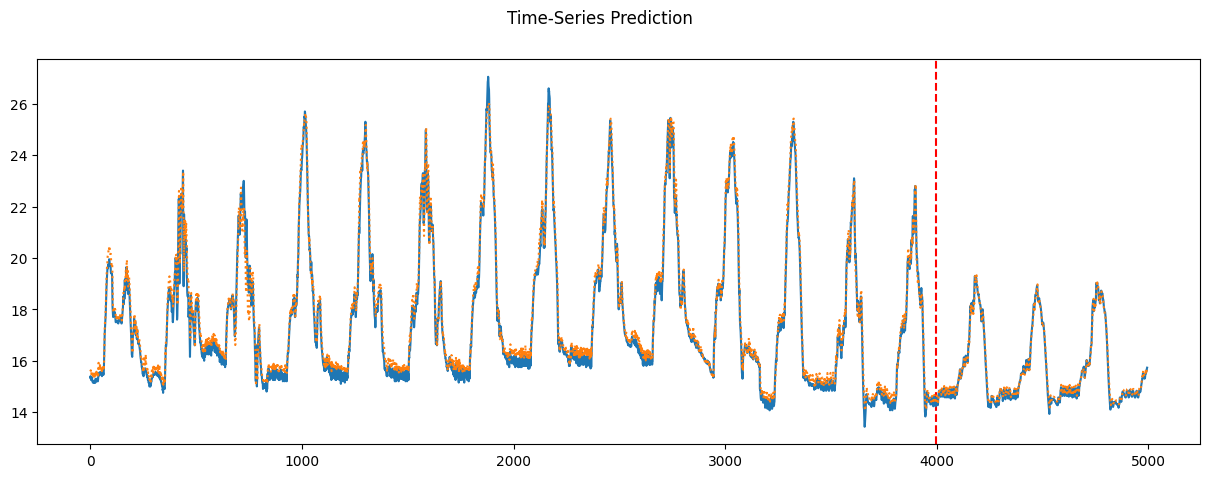

In [48]:
eval(lstm, dataX, dataY, train_size)

X dataset shape & prediction shape: torch.Size([999, 4, 3]) torch.Size([999, 1])
explained_variance:  0.9933
mean_squared_log_error:  1e-04
r2:  0.9924
MAE:  0.099
MSE:  0.0154
RMSE:  0.1239


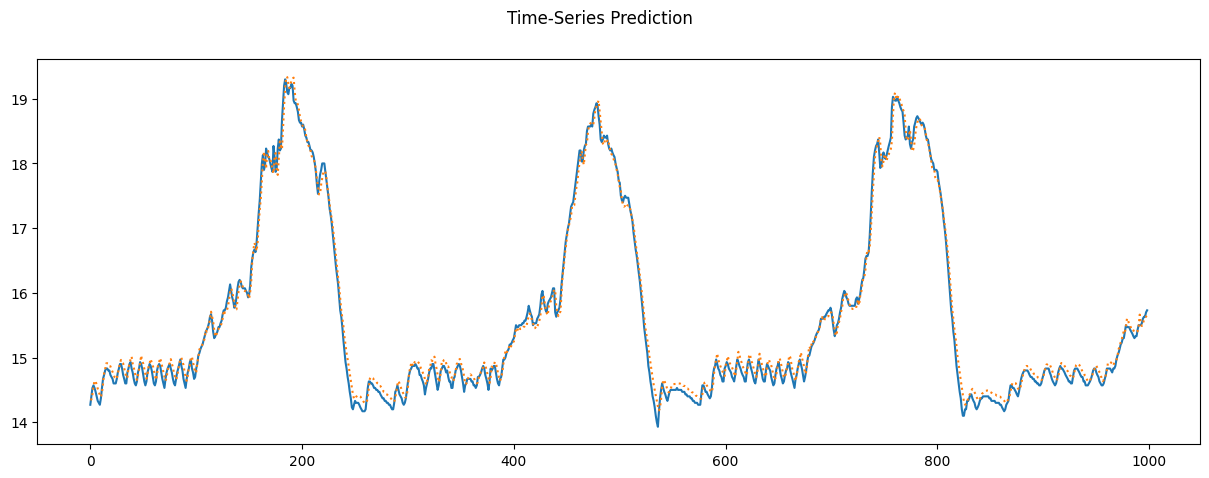

In [49]:
eval(lstm, testX, testY)